In [23]:
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import tensorflow as tf
Adam = tf.keras.optimizers.Adam
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import subplots
import plotly
from sklearn.model_selection import train_test_split

In [24]:
width = 28 # ปรับขนาดรูป
num_classes = 8
trainpath = '/Users/onna/Documents/krotom-train/img-eng/train'
testpath = '/Users/onna/Documents/krotom-train/img-eng/test'
trainImg = [trainpath + "/"+ f for f in listdir(trainpath)]
testImg = [testpath + "/"+ f for f in listdir(testpath)]

In [25]:
def img2data(path):
    rawImgs = []
    labels = []

    for imagePath in (path):
        for item in tqdm(listdir(imagePath)):
            file = join(imagePath, item)
            
            if file[-1] =='g':
                img = cv2.imread(file , cv2.COLOR_BGR2RGB) # ปรับสีรูป
                img = cv2.resize(img ,(width,width))
                rawImgs.append(img)

                name =  imagePath.split('/')
                l = name[len(name) - 1]
            #['Boiled_leaves', 'Green_stalk_GradeA', 'Green_stalk_GradeB', 'Green_stalk_GradeC', 'JUMBO', 'Red_stalk_GradeA', 'Red_stalk_GradeB', 'Red_stalk_GradeC']
            if l == 'Boiled_leaves':
                labels.append([1,0,0,0,0,0,0,0])         
            elif l == 'Green_stalk_GradeA':
                labels.append([0,1,0,0,0,0,0,0])  
            elif l == 'Green_stalk_GradeB':
                labels.append([0,0,1,0,0,0,0,0])
            elif l == 'Green_stalk_GradeC':
                labels.append([0,0,0,1,0,0,0,0])
            elif l == 'JUMBO':
                labels.append([0,0,0,0,1,0,0,0])
            elif l == 'Red_stalk_GradeA':
                labels.append([0,0,0,0,0,1,0,0])
            elif l == 'Red_stalk_GradeB':
                labels.append([0,0,0,0,0,0,1,0])
            elif l == 'Red_stalk_GradeC':
                labels.append([0,0,0,0,0,0,0,1])
    return rawImgs, labels

In [26]:
x_train, y_train = img2data(trainImg)

100%|██████████| 44/44 [00:00<00:00, 119.57it/s]


In [27]:
x_test, y_test = img2data(testImg)

100%|██████████| 10/10 [00:00<00:00, 94.72it/s]


In [28]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [29]:
x_train.shape,y_train.shape,x_test.shape, y_test.shape

((1381, 28, 28, 3), (1381, 8), (352, 28, 28, 3), (352, 8))

In [30]:
# train_data = x_train.reshape((x_train.shape[0], 28, 28, 1))
# test_data = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [31]:
# print(train_data.shape, test_data.shape)

In [32]:
NUM_CLASSES = 8
VAL_SIZE = 0.2
RANDOM_STATE = 99
BATCH_SIZE = 256

In [33]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_STATE)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1104, 28, 28, 3), (277, 28, 28, 3), (1104, 8), (277, 8))

In [34]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    plotly.offline.iplot(fig, filename='accuracy-loss')

In [35]:
datagen = ImageDataGenerator(
        rotation_range=0.05,    #Randomly rotate images in the range
        zoom_range=0.2,         #Randomly zoom image
        width_shift_range=0.1,  #Randomly shift images horizontally
        height_shift_range=0.1, #Randomly shift images vertically
        shear_range=0.05        #Randomly shear images
)

datagen.fit(x_train)

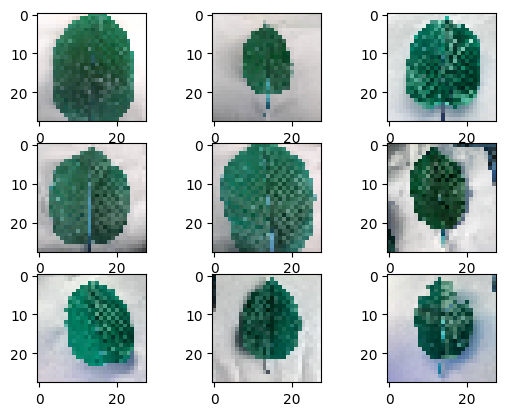

In [36]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

In [37]:
# model = Sequential()
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(width, width, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.3))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.3))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))


#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.30))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [38]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                      

In [39]:
# ถ้า val_loss ไม่น้อยลง {patience} epoch ติด จะทำการ lr = lr * {factor} แต่ lr ต่ำสุดไม่เกิน {min_lr}
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

# ตั้งชื่อไฟล์ที่จะเซฟ
filepath="weights_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint, rlrp]

In [40]:
NO_EPOCHS = 10000

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=NO_EPOCHS, validation_data = (x_val, y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                              callbacks=callbacks_list)

Epoch 1/10000
4/4 [==============================] - ETA: 0s - loss: 2.4687 - accuracy: 0.1851
Epoch 1: val_loss improved from inf to 2.06203, saving model to weights_best_lr_1_e-5.h5
4/4 [==============================] - 2s 266ms/step - loss: 2.4687 - accuracy: 0.1851 - val_loss: 2.0620 - val_accuracy: 0.2527 - lr: 0.0010
Epoch 2/10000
4/4 [==============================] - ETA: 0s - loss: 1.8682 - accuracy: 0.3915
Epoch 2: val_loss improved from 2.06203 to 1.94376, saving model to weights_best_lr_1_e-5.h5
4/4 [==============================] - 1s 230ms/step - loss: 1.8682 - accuracy: 0.3915 - val_loss: 1.9438 - val_accuracy: 0.3141 - lr: 0.0010
Epoch 3/10000
4/4 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.4528
Epoch 3: val_loss improved from 1.94376 to 1.88900, saving model to weights_best_lr_1_e-5.h5
4/4 [==============================] - 1s 217ms/step - loss: 1.6659 - accuracy: 0.4528 - val_loss: 1.8890 - val_accuracy: 0.3141 - lr: 0.0010
Epoch 4/10000


KeyboardInterrupt: 

In [41]:
plot_accuracy_and_loss(history)

In [42]:
score = model.evaluate(x_test, y_test,verbose=0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 1.876590371131897
Test Accuracy: 0.4857954680919647


In [47]:
import keras
modelLoad = keras.models.load_model("weights_best_lr_1_e-5.h5")

In [48]:
score = modelLoad.evaluate(x_test, y_test,verbose=0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 1.6939151287078857
Test Accuracy: 0.49147728085517883
